In [1]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 
import xarray as xr

import warnings

warnings.simplefilter("ignore")

import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from sklearn.utils import shuffle
import tensorflow.keras.backend as kbackend
import tensorflow.keras.models
from keras.utils import np_utils
from keras.regularizers import l2

tf.compat.v1.disable_eager_execution()

import innvestigate
import innvestigate.utils as iutils

2023-06-28 13:57:51.665151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 13:57:51.878016: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu7/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu7/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu7/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu7/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/home/shreyas/lis-1.4.43/installation/lib:/share/jdk-16.0.1/lib::
2023-06-28 13:57:51.878053: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ig

In [2]:
def basal_topology_func(x):
    b = 1.0 - 0.1*x
    return b

def solution(nx, nt, L, T, M, basal_topology_func):

    if len(M) != nx + 1:
        raise ValueError('M specified but len(M) != nx + 1')
        
    dx = L/nx
    dt = T/nt
    x = np.linspace(0,L,nx+1)
    t = np.linspace(0,T,nt+1)

    b = basal_topology_func(x)

    A = 1e-16
    rho = 920.0
    g = 9.2 
    n = 3

    C = 2*A/(n+2) * (rho*g)**n * (1e3)**n

    h = np.zeros((nx+1,nt+1))
    H = np.zeros((nx+1,nt+1))
    h[:,0] = b
    h[0,:] = b[0]
    h[-1,:] = b[-1]

    H[:,0] = h[:,0] - b
    H[0,:] = h[0,:] - b[0]
    H[-1,:] = h[-1,:] - b[-1]

    for i in range(1,len(t)):

        D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * ((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)

        phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

        h[1:nx,i] = h[1:nx,i-1] + M[1:nx]*dt - dt/dx * (phi[1:]-phi[:nx-1])
        h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]
        H[:,i] = np.maximum(h[:,i] - b, 0.)

        if not np.any(H[:,i]>=0.0):
            raise Exception("Something went wrong.")
            
    Volume = np.sum(H)*dx
    
    return H[int(nx/2),-1], h[int(nx/2),-1], Volume

In [3]:
L = 30.
T = 10.
nx = 300
nt = 12000
samples = 1000

M_samples = 0.01*np.random.rand(samples, nx+1)
H_samples = np.zeros((samples,1), dtype = np.float64)
Volume_samples = np.zeros((samples,1), dtype = np.float64)

for sample in range(samples):
    if (sample+1) % 10 == 0:
        print(f'Sample #{sample+1}', end='\r')
    H_samples[sample], _, Volume_samples[sample] = solution(nx, nt, L, T, M_samples[sample], basal_topology_func)

In [4]:
keras.backend.clear_session()

inputs = Input(shape=(nx+1,))
dense1 = Dense(10, activation='relu')
dense2 = Dense(1, activation='linear', use_bias=False)

x = dense1(inputs)
x = dense2(x)

model = keras.Model(inputs=inputs, outputs=x) 

mod_h5 = 'model.h5'

checkpoint = ModelCheckpoint(mod_h5, monitor='val_loss',
                             verbose=1,save_best_only=True)
        
callbacks = [checkpoint]
model.compile(optimizer='adam',
            loss='mse', metrics=['mae'])

fit = model.fit(M_samples, H_samples,
            batch_size=10,
            epochs=1000, 
            shuffle=True,
            validation_split = 0.2, 
            callbacks=callbacks)

Train on 800 samples, validate on 200 samples
Epoch 1/1000


2023-06-28 14:13:25.463165: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu7/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu7/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu7/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu7/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/home/shreyas/lis-1.4.43/installation/lib:/share/jdk-16.0.1/lib::
2023-06-28 14:13:25.463231: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-28 14:13:25.463288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c1-3): /proc/driver/nvidia/version does not exist
2023-06-28 14:13:25.464037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binar

660/800 [=======================>......] - ETA: 0s - loss: 6.0223e-04 - mae: 0.0200
Epoch 1: val_loss improved from inf to 0.00058, saving model to model.h5
800/800 [==============================] - 0s 427us/sample - loss: 5.6810e-04 - mae: 0.0195 - val_loss: 5.7712e-04 - val_mae: 0.0206
Epoch 2/1000
330/800 [===========>..................] - ETA: 0s - loss: 4.6609e-04 - mae: 0.0182

2023-06-28 14:13:25.836006: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/mul' id:88 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


660/800 [=======================>......] - ETA: 0s - loss: 4.4630e-04 - mae: 0.0179
Epoch 2: val_loss did not improve from 0.00058
800/800 [==============================] - 0s 185us/sample - loss: 4.4719e-04 - mae: 0.0179 - val_loss: 6.0355e-04 - val_mae: 0.0205
Epoch 3/1000
680/800 [========================>.....] - ETA: 0s - loss: 4.2584e-04 - mae: 0.0174
Epoch 3: val_loss improved from 0.00058 to 0.00056, saving model to model.h5
800/800 [==============================] - 0s 198us/sample - loss: 4.3423e-04 - mae: 0.0176 - val_loss: 5.6382e-04 - val_mae: 0.0201
Epoch 4/1000
750/800 [===========================>..] - ETA: 0s - loss: 4.0810e-04 - mae: 0.0171
Epoch 4: val_loss improved from 0.00056 to 0.00054, saving model to model.h5
800/800 [==============================] - 0s 191us/sample - loss: 4.1276e-04 - mae: 0.0172 - val_loss: 5.3744e-04 - val_mae: 0.0200
Epoch 5/1000
720/800 [==========================>...] - ETA: 0s - loss: 4.0844e-04 - mae: 0.0171
Epoch 5: val_loss improve

Epoch 29/1000
670/800 [========================>.....] - ETA: 0s - loss: 7.1639e-05 - mae: 0.0067
Epoch 29: val_loss did not improve from 0.00020
800/800 [==============================] - 0s 178us/sample - loss: 6.8021e-05 - mae: 0.0065 - val_loss: 2.2345e-04 - val_mae: 0.0118
Epoch 30/1000
700/800 [=========================>....] - ETA: 0s - loss: 6.3094e-05 - mae: 0.0063
Epoch 30: val_loss improved from 0.00020 to 0.00018, saving model to model.h5
800/800 [==============================] - 0s 197us/sample - loss: 6.4940e-05 - mae: 0.0063 - val_loss: 1.8224e-04 - val_mae: 0.0112
Epoch 31/1000
700/800 [=========================>....] - ETA: 0s - loss: 6.5496e-05 - mae: 0.0065
Epoch 31: val_loss improved from 0.00018 to 0.00017, saving model to model.h5
800/800 [==============================] - 0s 199us/sample - loss: 6.7086e-05 - mae: 0.0066 - val_loss: 1.7477e-04 - val_mae: 0.0111
Epoch 32/1000
770/800 [===========================>..] - ETA: 0s - loss: 5.7981e-05 - mae: 0.0060
Epoch

680/800 [========================>.....] - ETA: 0s - loss: 1.9522e-05 - mae: 0.0035
Epoch 84: val_loss did not improve from 0.00005
800/800 [==============================] - 0s 176us/sample - loss: 1.9836e-05 - mae: 0.0036 - val_loss: 6.0074e-05 - val_mae: 0.0061
Epoch 85/1000
680/800 [========================>.....] - ETA: 0s - loss: 1.9334e-05 - mae: 0.0036
Epoch 85: val_loss did not improve from 0.00005
800/800 [==============================] - 0s 176us/sample - loss: 1.9312e-05 - mae: 0.0036 - val_loss: 4.9867e-05 - val_mae: 0.0059
Epoch 86/1000
790/800 [============================>.] - ETA: 0s - loss: 1.9107e-05 - mae: 0.0035
Epoch 86: val_loss did not improve from 0.00005
800/800 [==============================] - 0s 154us/sample - loss: 1.9138e-05 - mae: 0.0035 - val_loss: 4.9350e-05 - val_mae: 0.0057
Epoch 87/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.6786e-05 - mae: 0.0033
Epoch 87: val_loss did not improve from 0.00005
800/800 [======================

Epoch 113/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.6817e-05 - mae: 0.0033
Epoch 113: val_loss did not improve from 0.00005
800/800 [==============================] - 0s 167us/sample - loss: 1.7625e-05 - mae: 0.0033 - val_loss: 4.9164e-05 - val_mae: 0.0057
Epoch 114/1000
800/800 [==============================] - ETA: 0s - loss: 2.0767e-05 - mae: 0.0037
Epoch 114: val_loss did not improve from 0.00005
800/800 [==============================] - 0s 149us/sample - loss: 2.0767e-05 - mae: 0.0037 - val_loss: 5.1988e-05 - val_mae: 0.0060
Epoch 115/1000
480/800 [=================>............] - ETA: 0s - loss: 1.7082e-05 - mae: 0.0032
Epoch 115: val_loss did not improve from 0.00005
800/800 [==============================] - 0s 134us/sample - loss: 1.7566e-05 - mae: 0.0033 - val_loss: 4.6897e-05 - val_mae: 0.0056
Epoch 116/1000
440/800 [===============>..............] - ETA: 0s - loss: 2.0499e-05 - mae: 0.0037
Epoch 116: val_loss did not improve from 0.00005
800/800 [

Epoch 142/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.7852e-05 - mae: 0.0033
Epoch 142: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 166us/sample - loss: 1.8172e-05 - mae: 0.0034 - val_loss: 4.7662e-05 - val_mae: 0.0056
Epoch 143/1000
780/800 [============================>.] - ETA: 0s - loss: 1.7938e-05 - mae: 0.0034
Epoch 143: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 1.8071e-05 - mae: 0.0034 - val_loss: 5.3842e-05 - val_mae: 0.0059
Epoch 144/1000
800/800 [==============================] - ETA: 0s - loss: 1.6721e-05 - mae: 0.0033
Epoch 144: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 151us/sample - loss: 1.6721e-05 - mae: 0.0033 - val_loss: 4.5935e-05 - val_mae: 0.0055
Epoch 145/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.5240e-05 - mae: 0.0031
Epoch 145: val_loss did not improve from 0.00004
800/800 [

Epoch 171/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.9083e-05 - mae: 0.0035
Epoch 171: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 149us/sample - loss: 1.8050e-05 - mae: 0.0034 - val_loss: 4.4774e-05 - val_mae: 0.0055
Epoch 172/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.9192e-05 - mae: 0.0035
Epoch 172: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 167us/sample - loss: 1.8958e-05 - mae: 0.0035 - val_loss: 5.3697e-05 - val_mae: 0.0059
Epoch 173/1000
790/800 [============================>.] - ETA: 0s - loss: 1.7968e-05 - mae: 0.0034
Epoch 173: val_loss improved from 0.00004 to 0.00004, saving model to model.h5
800/800 [==============================] - 0s 178us/sample - loss: 1.7799e-05 - mae: 0.0034 - val_loss: 4.4374e-05 - val_mae: 0.0055
Epoch 174/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.6927e-05 - mae: 0.0033
Epoch 174: val_loss did not 

Epoch 200/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.6761e-05 - mae: 0.0033
Epoch 200: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 149us/sample - loss: 1.6468e-05 - mae: 0.0032 - val_loss: 4.4830e-05 - val_mae: 0.0054
Epoch 201/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.6147e-05 - mae: 0.0032
Epoch 201: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.6468e-05 - mae: 0.0032 - val_loss: 4.5617e-05 - val_mae: 0.0055
Epoch 202/1000
780/800 [============================>.] - ETA: 0s - loss: 2.0119e-05 - mae: 0.0036
Epoch 202: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 157us/sample - loss: 2.0079e-05 - mae: 0.0036 - val_loss: 4.5168e-05 - val_mae: 0.0055
Epoch 203/1000
400/800 [==============>...............] - ETA: 0s - loss: 1.6029e-05 - mae: 0.0032
Epoch 203: val_loss did not improve from 0.00004
800/800 [

Epoch 258/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.5666e-05 - mae: 0.0032
Epoch 258: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.6141e-05 - mae: 0.0032 - val_loss: 4.5888e-05 - val_mae: 0.0055
Epoch 259/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.8343e-05 - mae: 0.0034
Epoch 259: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 150us/sample - loss: 1.9778e-05 - mae: 0.0035 - val_loss: 4.5796e-05 - val_mae: 0.0055
Epoch 260/1000
730/800 [==========================>...] - ETA: 0s - loss: 1.7098e-05 - mae: 0.0033
Epoch 260: val_loss improved from 0.00004 to 0.00004, saving model to model.h5
800/800 [==============================] - 0s 194us/sample - loss: 1.6685e-05 - mae: 0.0033 - val_loss: 4.3698e-05 - val_mae: 0.0055
Epoch 261/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.6349e-05 - mae: 0.0033
Epoch 261: val_loss did not 

440/800 [===============>..............] - ETA: 0s - loss: 1.6928e-05 - mae: 0.0033
Epoch 287: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 1.7650e-05 - mae: 0.0034 - val_loss: 5.0270e-05 - val_mae: 0.0058
Epoch 288/1000
710/800 [=========================>....] - ETA: 0s - loss: 2.0008e-05 - mae: 0.0036
Epoch 288: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 168us/sample - loss: 1.9736e-05 - mae: 0.0036 - val_loss: 4.7788e-05 - val_mae: 0.0056
Epoch 289/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.5177e-05 - mae: 0.0031
Epoch 289: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.6024e-05 - mae: 0.0032 - val_loss: 4.4794e-05 - val_mae: 0.0055
Epoch 290/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.6085e-05 - mae: 0.0031
Epoch 290: val_loss did not improve from 0.00004
800/800 [===============

650/800 [=======================>......] - ETA: 0s - loss: 1.8937e-05 - mae: 0.0035
Epoch 345: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 178us/sample - loss: 1.9011e-05 - mae: 0.0035 - val_loss: 4.4038e-05 - val_mae: 0.0054
Epoch 346/1000
780/800 [============================>.] - ETA: 0s - loss: 1.6124e-05 - mae: 0.0032
Epoch 346: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 157us/sample - loss: 1.6393e-05 - mae: 0.0032 - val_loss: 5.1161e-05 - val_mae: 0.0058
Epoch 347/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.7460e-05 - mae: 0.0033
Epoch 347: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 157us/sample - loss: 1.7232e-05 - mae: 0.0033 - val_loss: 4.5893e-05 - val_mae: 0.0055
Epoch 348/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.7923e-05 - mae: 0.0033
Epoch 348: val_loss did not improve from 0.00004
800/800 [===============

400/800 [==============>...............] - ETA: 0s - loss: 1.9166e-05 - mae: 0.0035
Epoch 403: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 1.7979e-05 - mae: 0.0034 - val_loss: 4.3873e-05 - val_mae: 0.0054
Epoch 404/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.7081e-05 - mae: 0.0033
Epoch 404: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 147us/sample - loss: 1.7818e-05 - mae: 0.0034 - val_loss: 4.7789e-05 - val_mae: 0.0057
Epoch 405/1000
690/800 [========================>.....] - ETA: 0s - loss: 1.5756e-05 - mae: 0.0031
Epoch 405: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 173us/sample - loss: 1.6997e-05 - mae: 0.0033 - val_loss: 4.5752e-05 - val_mae: 0.0056
Epoch 406/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.6855e-05 - mae: 0.0032
Epoch 406: val_loss did not improve from 0.00004
800/800 [===============

390/800 [=============>................] - ETA: 0s - loss: 1.8166e-05 - mae: 0.0034
Epoch 461: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.8344e-05 - mae: 0.0034 - val_loss: 4.6332e-05 - val_mae: 0.0055
Epoch 462/1000
790/800 [============================>.] - ETA: 0s - loss: 1.7301e-05 - mae: 0.0033
Epoch 462: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 158us/sample - loss: 1.7253e-05 - mae: 0.0033 - val_loss: 4.5119e-05 - val_mae: 0.0055
Epoch 463/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.6836e-05 - mae: 0.0032
Epoch 463: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 154us/sample - loss: 1.6785e-05 - mae: 0.0032 - val_loss: 4.5050e-05 - val_mae: 0.0055
Epoch 464/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.5604e-05 - mae: 0.0031
Epoch 464: val_loss did not improve from 0.00004
800/800 [===============

Epoch 490/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.6451e-05 - mae: 0.0033
Epoch 490: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 135us/sample - loss: 1.6506e-05 - mae: 0.0032 - val_loss: 4.3948e-05 - val_mae: 0.0055
Epoch 491/1000
780/800 [============================>.] - ETA: 0s - loss: 1.8229e-05 - mae: 0.0034
Epoch 491: val_loss improved from 0.00004 to 0.00004, saving model to model.h5
800/800 [==============================] - 0s 174us/sample - loss: 1.8252e-05 - mae: 0.0034 - val_loss: 4.3375e-05 - val_mae: 0.0054
Epoch 492/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.7638e-05 - mae: 0.0033
Epoch 492: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 159us/sample - loss: 1.7825e-05 - mae: 0.0033 - val_loss: 6.9958e-05 - val_mae: 0.0067
Epoch 493/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.7872e-05 - mae: 0.0034
Epoch 493: val_loss did not 

720/800 [==========================>...] - ETA: 0s - loss: 1.5840e-05 - mae: 0.0032
Epoch 519: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 168us/sample - loss: 1.6237e-05 - mae: 0.0032 - val_loss: 4.5355e-05 - val_mae: 0.0055
Epoch 520/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.8315e-05 - mae: 0.0034
Epoch 520: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 166us/sample - loss: 1.8021e-05 - mae: 0.0034 - val_loss: 5.6889e-05 - val_mae: 0.0060
Epoch 521/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.8220e-05 - mae: 0.0034
Epoch 521: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.7508e-05 - mae: 0.0033 - val_loss: 4.4001e-05 - val_mae: 0.0054
Epoch 522/1000
390/800 [=============>................] - ETA: 0s - loss: 1.8763e-05 - mae: 0.0035
Epoch 522: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.4830e-05 - mae: 0.0031
Epoch 577: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 144us/sample - loss: 1.7625e-05 - mae: 0.0033 - val_loss: 5.6011e-05 - val_mae: 0.0060
Epoch 578/1000
710/800 [=========================>....] - ETA: 0s - loss: 1.8732e-05 - mae: 0.0034
Epoch 578: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 169us/sample - loss: 1.8951e-05 - mae: 0.0034 - val_loss: 5.1607e-05 - val_mae: 0.0058
Epoch 579/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.6601e-05 - mae: 0.0032
Epoch 579: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 168us/sample - loss: 1.7020e-05 - mae: 0.0033 - val_loss: 4.3835e-05 - val_mae: 0.0054
Epoch 580/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.6043e-05 - mae: 0.0031
Epoch 580: val_loss did not improve from 0.00004
800/800 [===============

710/800 [=========================>....] - ETA: 0s - loss: 1.7123e-05 - mae: 0.0033
Epoch 635: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 174us/sample - loss: 1.7623e-05 - mae: 0.0034 - val_loss: 4.4120e-05 - val_mae: 0.0054
Epoch 636/1000
720/800 [==========================>...] - ETA: 0s - loss: 1.8286e-05 - mae: 0.0034
Epoch 636: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 176us/sample - loss: 1.8359e-05 - mae: 0.0034 - val_loss: 4.8332e-05 - val_mae: 0.0057
Epoch 637/1000
680/800 [========================>.....] - ETA: 0s - loss: 1.8549e-05 - mae: 0.0034
Epoch 637: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 176us/sample - loss: 1.8967e-05 - mae: 0.0034 - val_loss: 4.5686e-05 - val_mae: 0.0055
Epoch 638/1000
700/800 [=========================>....] - ETA: 0s - loss: 1.5389e-05 - mae: 0.0031
Epoch 638: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.4640e-05 - mae: 0.0031
Epoch 693: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 1.5794e-05 - mae: 0.0032 - val_loss: 4.4217e-05 - val_mae: 0.0054
Epoch 694/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.6377e-05 - mae: 0.0032
Epoch 694: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 160us/sample - loss: 1.6300e-05 - mae: 0.0032 - val_loss: 4.7285e-05 - val_mae: 0.0056
Epoch 695/1000
780/800 [============================>.] - ETA: 0s - loss: 1.6083e-05 - mae: 0.0032
Epoch 695: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 158us/sample - loss: 1.6126e-05 - mae: 0.0032 - val_loss: 4.6099e-05 - val_mae: 0.0055
Epoch 696/1000
790/800 [============================>.] - ETA: 0s - loss: 1.6533e-05 - mae: 0.0032
Epoch 696: val_loss did not improve from 0.00004
800/800 [===============

790/800 [============================>.] - ETA: 0s - loss: 1.6028e-05 - mae: 0.0032
Epoch 751: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 154us/sample - loss: 1.5971e-05 - mae: 0.0032 - val_loss: 4.4825e-05 - val_mae: 0.0055
Epoch 752/1000
790/800 [============================>.] - ETA: 0s - loss: 1.7505e-05 - mae: 0.0033
Epoch 752: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 157us/sample - loss: 1.7507e-05 - mae: 0.0033 - val_loss: 4.4699e-05 - val_mae: 0.0054
Epoch 753/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.6840e-05 - mae: 0.0032
Epoch 753: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 164us/sample - loss: 1.6894e-05 - mae: 0.0033 - val_loss: 5.0057e-05 - val_mae: 0.0057
Epoch 754/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.6358e-05 - mae: 0.0033
Epoch 754: val_loss did not improve from 0.00004
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.5062e-05 - mae: 0.0030
Epoch 809: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 133us/sample - loss: 1.6048e-05 - mae: 0.0032 - val_loss: 4.4012e-05 - val_mae: 0.0054
Epoch 810/1000
740/800 [==========================>...] - ETA: 0s - loss: 1.6902e-05 - mae: 0.0033
Epoch 810: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 158us/sample - loss: 1.7213e-05 - mae: 0.0033 - val_loss: 4.6525e-05 - val_mae: 0.0056
Epoch 811/1000
460/800 [================>.............] - ETA: 0s - loss: 1.5754e-05 - mae: 0.0032
Epoch 811: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 131us/sample - loss: 1.7208e-05 - mae: 0.0033 - val_loss: 5.3067e-05 - val_mae: 0.0059
Epoch 812/1000
460/800 [================>.............] - ETA: 0s - loss: 2.0287e-05 - mae: 0.0037
Epoch 812: val_loss did not improve from 0.00004
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.6411e-05 - mae: 0.0032
Epoch 867: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 137us/sample - loss: 1.6029e-05 - mae: 0.0032 - val_loss: 4.4421e-05 - val_mae: 0.0055
Epoch 868/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.5891e-05 - mae: 0.0032
Epoch 868: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 134us/sample - loss: 1.7543e-05 - mae: 0.0033 - val_loss: 4.6622e-05 - val_mae: 0.0055
Epoch 869/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.7201e-05 - mae: 0.0033
Epoch 869: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.7391e-05 - mae: 0.0033 - val_loss: 4.5051e-05 - val_mae: 0.0054
Epoch 870/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.6936e-05 - mae: 0.0033
Epoch 870: val_loss did not improve from 0.00004
800/800 [===============

650/800 [=======================>......] - ETA: 0s - loss: 1.7566e-05 - mae: 0.0033
Epoch 925: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 193us/sample - loss: 1.7656e-05 - mae: 0.0034 - val_loss: 4.6216e-05 - val_mae: 0.0055
Epoch 926/1000
650/800 [=======================>......] - ETA: 0s - loss: 1.8493e-05 - mae: 0.0034
Epoch 926: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 182us/sample - loss: 1.8061e-05 - mae: 0.0034 - val_loss: 4.5431e-05 - val_mae: 0.0055
Epoch 927/1000
750/800 [===========================>..] - ETA: 0s - loss: 1.6623e-05 - mae: 0.0032
Epoch 927: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 168us/sample - loss: 1.6813e-05 - mae: 0.0032 - val_loss: 4.4240e-05 - val_mae: 0.0055
Epoch 928/1000
630/800 [======================>.......] - ETA: 0s - loss: 1.7428e-05 - mae: 0.0033
Epoch 928: val_loss did not improve from 0.00004
800/800 [===============

480/800 [=================>............] - ETA: 0s - loss: 1.5588e-05 - mae: 0.0032
Epoch 983: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 126us/sample - loss: 1.5986e-05 - mae: 0.0032 - val_loss: 4.5667e-05 - val_mae: 0.0055
Epoch 984/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.5762e-05 - mae: 0.0031
Epoch 984: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 142us/sample - loss: 1.6690e-05 - mae: 0.0032 - val_loss: 4.3971e-05 - val_mae: 0.0054
Epoch 985/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.6643e-05 - mae: 0.0033
Epoch 985: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 137us/sample - loss: 1.8558e-05 - mae: 0.0034 - val_loss: 4.6303e-05 - val_mae: 0.0055
Epoch 986/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.7451e-05 - mae: 0.0033
Epoch 986: val_loss did not improve from 0.00004
800/800 [===============

In [5]:
inputs = Input(shape=(nx+1,))
dense1 = Dense(10, activation='relu')
dense2 = Dense(1, activation='linear', use_bias=False)

x = dense1(inputs)
x = dense2(x)

best_model = keras.Model(inputs=inputs, outputs=x) 
best_model.load_weights(mod_h5)
best_model.compile(loss='mse', optimizer='adam',metrics=['mae'])

H_pred = best_model.predict(M_samples)

2023-06-28 14:15:33.522609: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_3/kernel/Assign' id:321 op device:{requested: '', assigned: ''} def:{{{node dense_3/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_3/kernel, dense_3/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 14:15:33.594155: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_3/MatMul' id:324 op device:{requested: '', assigned: ''} def:{{{node dense_3/MatMul}} = MatMul[T=DT_FLOAT, _has_manual_control_dependencies=true, transpose_a=false, transpose_b=false](dense_2/Relu, dense_3/MatMul/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in 

2023-06-28 14:15:33.864249: W tensorflow/c/c_api.cc:291] Operation '{name:'kernel_3/Assign' id:489 op device:{requested: '', assigned: ''} def:{{{node kernel_3/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_3, kernel_3/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 14:15:33.904108: W tensorflow/c/c_api.cc:291] Operation '{name:'gradients/MaxNeuronSelection/Max_grad/range' id:499 op device:{requested: '', assigned: ''} def:{{{node gradients/MaxNeuronSelection/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection/Max"], _has_manual_control_dependencies=true](gradients/MaxNeuronSelection/Max_grad/range/start, gradients/MaxNeuronSelection/Max_grad/Size, gradients/MaxNeuronSelection/Max_grad/range

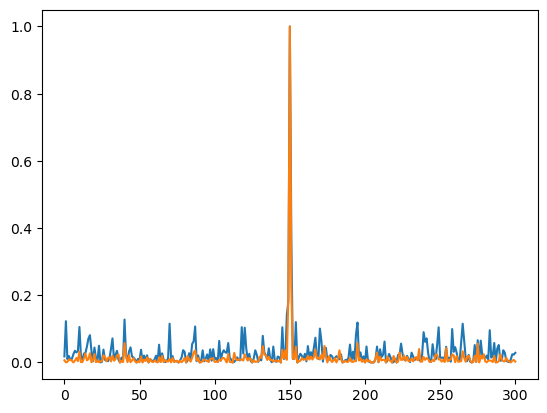

In [6]:
analyzer_gradient = innvestigate.create_analyzer("lrp.alpha_1_beta_0", best_model)
a_alb0 = np.zeros((samples, nx+1), dtype = np.float64)
for sample in range(samples):
    a_alb0[sample] = analyzer_gradient.analyze(M_samples[sample][np.newaxis,:])
    a_alb0[sample] /= np.max(np.abs(a_alb0[sample]))

plt.plot(a_alb0[0])
plt.plot(a_alb0[10])

2023-06-28 14:15:35.594522: W tensorflow/c/c_api.cc:291] Operation '{name:'kernel_4/Assign' id:605 op device:{requested: '', assigned: ''} def:{{{node kernel_4/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_4, kernel_4/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 14:15:35.632798: W tensorflow/c/c_api.cc:291] Operation '{name:'gradients_5/MaxNeuronSelection_1/Max_grad/range' id:634 op device:{requested: '', assigned: ''} def:{{{node gradients_5/MaxNeuronSelection_1/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection_1/Max"], _has_manual_control_dependencies=true](gradients_5/MaxNeuronSelection_1/Max_grad/range/start, gradients_5/MaxNeuronSelection_1/Max_grad/Size, gradients_5/MaxNeuronSele

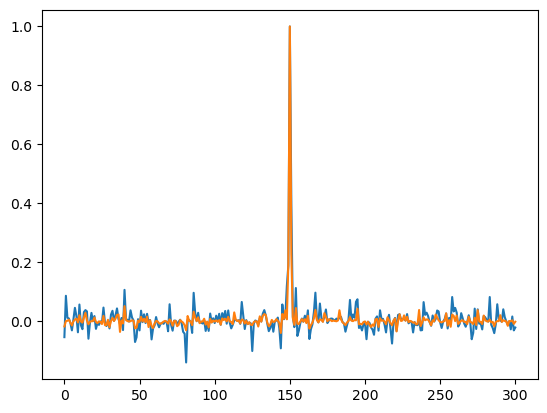

In [7]:
analyzer_gradient = innvestigate.create_analyzer("lrp.z", best_model)
a_z = np.zeros((samples, nx+1), dtype = np.float64)
for sample in range(samples):
    a_z[sample] = analyzer_gradient.analyze(M_samples[sample][np.newaxis,:])
    a_z[sample] /= np.max(np.abs(a_z[sample]))

plt.plot(a_z[0])
plt.plot(a_z[10])

In [8]:
def regression_letzgus(model, input_, y_ref, step_width=0.00005, max_it=10e4, method = "flood"):
    
    ### Finding a_ref for a given y_ref
    
    if method == "flood":
        
        model_part = Model(inputs=model.input,
                          outputs=model.layers[-2].output)
        a_ref = model_part.predict(input_)[0,:]
        a_ref = a_ref[:, np.newaxis]
        update = np.ones(a_ref.shape) * step_width
        
        y = model.predict(input_)
        
        counter = 0
        
        if y > y_ref:
            
            while y >= y_ref:
                
                a_ref = np.maximum(np.zeros(a_ref.shape),a_ref-update)
                y = np.dot(model.layers[-1].get_weights()[0][:,0], a_ref[:,0])
                counter +=1 
                print(f'iteration {counter} - y: {y}', end='\r')
                if counter > max_it:
                    print(f'! reference value {y_ref} was not reached within {round(max_it)} iterations!')
                    break
        else:
            
            while y <= y_ref:
                
                a_ref = np.maximum(np.zeros(a_ref.shape),a_ref+update)
                y = np.dot(model.layers[-1].get_weights()[0][:,0], a_ref[:,0])
                counter +=1 
                print(f'iteration {counter} - y: {y}', end='\r')
                if counter > max_it:
                    print(f'! reference value {y_ref} was not reached within {round(max_it)} iterations!')
                    break
                    
    else: 
        
        raise ValueError("The only methods available are : flood")
        
    return a_ref

def triplicated_model(best_model, a_ref):
    
    # get weights and biases
    W_in = best_model.layers[-2].get_weights()[0]
    W_out = best_model.layers[-1].get_weights()[0]
    bias_in = best_model.layers[-2].get_weights()[1]

    inputs = Input(shape=(nx+1,))

    # layer_dict = dict([(layer.name, layer) for layer in model.layers[:-2]])
    # weights = layer_dict['some_name'].get_weights()

    dense11 = Dense(10, activation='relu', name='dense11')
    dense12 = Dense(10, activation='relu', name='dense12')
    dense13 = Dense(10, activation='relu', name='dense13')
    dense21 = Dense(1, activation='linear', use_bias=False, name='dense21')
    dense22 = Dense(1, activation='linear', use_bias=False, name='dense22')
    dense23 = Dense(1, activation='linear', use_bias=False, name='dense23')

    x1 = dense11(inputs)
    x2 = dense12(inputs)
    x3 = dense13(inputs)

    x1 = dense21(x1)
    x2 = dense22(x2)
    x3 = dense23(x3)

    model = keras.Model(inputs=inputs, outputs=x1+x2+x3) 
    
    def getLayerIndexByName(model, layername):
        for idx, layer in enumerate(model.layers):
            if layer.name == layername:
                return idx
        raise Exception(f"layername: {layername} not found.")
            
    model.layers[getLayerIndexByName(model, 'dense11')].set_weights([W_in, bias_in-a_ref[:,0]])
    model.layers[getLayerIndexByName(model, 'dense12')].set_weights([-W_in, -bias_in])                 
    model.layers[getLayerIndexByName(model, 'dense13')].set_weights([-W_in, -bias_in+a_ref[:,0]])
    
    model.layers[getLayerIndexByName(model, 'dense21')].set_weights([W_out])
    model.layers[getLayerIndexByName(model, 'dense22')].set_weights([W_out])
    model.layers[getLayerIndexByName(model, 'dense23')].set_weights([-W_out])
    
    model.compile(loss='mse', optimizer='adam',metrics=['mae'])
    
    return model

In [9]:
index = 0
y = best_model.predict(M_samples[np.newaxis, index])
y_ref = y / 2.0

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, index], y_ref)

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
tri_model = triplicated_model(model_reg, a_ref)
y_reg = tri_model.predict(M_samples[np.newaxis, index])


y_ref, y-y_reg, y, y_reg

2023-06-28 15:12:54.246474: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/Relu' id:308 op device:{requested: '', assigned: ''} def:{{{node dense_2/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:12:54.273556: W tensorflow/c/c_api.cc:291] Operation '{name:'total_2/Assign' id:695 op device:{requested: '', assigned: ''} def:{{{node total_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_2, total_2/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:12:54.312869: W tensorf

2023-06-28 15:12:54.455653: W tensorflow/c/c_api.cc:291] Operation '{name:'total_3/Assign' id:744 op device:{requested: '', assigned: ''} def:{{{node total_3/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_3, total_3/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:12:54.883066: W tensorflow/c/c_api.cc:291] Operation '{name:'dense13/bias/Assign' id:853 op device:{requested: '', assigned: ''} def:{{{node dense13/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense13/bias, dense13/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes 

(array([[0.01155187]], dtype=float32),
 array([[0.01146248]], dtype=float32),
 array([[0.02310375]], dtype=float32),
 array([[0.01164127]], dtype=float32))

In [10]:
index = 0
y = best_model.predict(M_samples[np.newaxis, index])
y_ref = y * 2.0

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, index], y_ref)

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
tri_model = triplicated_model(model_reg, a_ref)
y_reg = tri_model.predict(M_samples[np.newaxis, index])

y_ref, y-y_reg, y, y_reg

2023-06-28 15:13:07.175773: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/Relu' id:308 op device:{requested: '', assigned: ''} def:{{{node dense_2/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:13:07.208354: W tensorflow/c/c_api.cc:291] Operation '{name:'total_5/Assign' id:999 op device:{requested: '', assigned: ''} def:{{{node total_5/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_5, total_5/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:13:07.252671: W tensorf

2023-06-28 15:13:07.495566: W tensorflow/c/c_api.cc:291] Operation '{name:'total_6/Assign' id:1048 op device:{requested: '', assigned: ''} def:{{{node total_6/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_6, total_6/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:13:07.683164: W tensorflow/c/c_api.cc:291] Operation '{name:'dense13_1/kernel/Assign' id:1152 op device:{requested: '', assigned: ''} def:{{{node dense13_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense13_1/kernel, dense13_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in t

(array([[0.0462075]], dtype=float32),
 array([[0.04625454]], dtype=float32),
 array([[0.02310375]], dtype=float32),
 array([[-0.02315079]], dtype=float32))

In [11]:
def triplicated_model_LRP_compatible(best_model, a_ref):
    
    # get weights and biases
    W_in = best_model.layers[-2].get_weights()[0]
    W_out = best_model.layers[-1].get_weights()[0]
    bias_in = best_model.layers[-2].get_weights()[1]

    inputs = Input(shape=(nx+1,))

    # layer_dict = dict([(layer.name, layer) for layer in model.layers[:-2]])
    # weights = layer_dict['some_name'].get_weights()

    dense11 = Dense(10, activation='relu', name='dense11')
    dense12 = Dense(10, activation='relu', name='dense12')
    dense13 = Dense(10, activation='relu', name='dense13')
    dense21 = Dense(1, activation='linear', use_bias=False, name='dense21')
    dense22 = Dense(1, activation='linear', use_bias=False, name='dense22')
    dense23 = Dense(1, activation='linear', use_bias=False, name='dense23')

    x1 = dense11(inputs)
    x2 = dense12(inputs)
    x3 = dense13(inputs)

    x1 = dense21(x1)
    x2 = dense22(x2)
    x3 = dense23(x3)

    model1 = keras.Model(inputs=inputs, outputs=x1)
    model2 = keras.Model(inputs=inputs, outputs=x2) 
    model3 = keras.Model(inputs=inputs, outputs=x3) 
    
    def getLayerIndexByName(model, layername):
        for idx, layer in enumerate(model.layers):
            if layer.name == layername:
                return idx
            
    model1.layers[getLayerIndexByName(model1, 'dense11')].set_weights([W_in, bias_in-a_ref[:,0]])
    model2.layers[getLayerIndexByName(model2, 'dense12')].set_weights([-W_in, -bias_in])                 
    model3.layers[getLayerIndexByName(model3, 'dense13')].set_weights([-W_in, -bias_in+a_ref[:,0]])
    
    model1.layers[getLayerIndexByName(model1, 'dense21')].set_weights([W_out])
    model2.layers[getLayerIndexByName(model2, 'dense22')].set_weights([W_out])
    model3.layers[getLayerIndexByName(model3, 'dense23')].set_weights([-W_out])
    
    model1.compile(loss='mse', optimizer='adam',metrics=['mae'])
    model2.compile(loss='mse', optimizer='adam',metrics=['mae'])
    model3.compile(loss='mse', optimizer='adam',metrics=['mae'])
    
    return model1, model2, model3

In [12]:
index = 0
y = best_model.predict(M_samples[np.newaxis, index])
y_ref = y * 2.0

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, 0], y_ref)

model1, model2, model3 = triplicated_model_LRP_compatible(best_model, a_ref)
y1 = model1.predict(M_samples[np.newaxis, index])
y2 = model1.predict(M_samples[np.newaxis, index])
y3 = model1.predict(M_samples[np.newaxis, index])

analyzer_gradient1 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model1)
analyzer_gradient2 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model2)
analyzer_gradient3 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model3)
a1 = np.zeros((samples, nx+1), dtype = np.float64)
a2 = np.zeros((samples, nx+1), dtype = np.float64)
a3 = np.zeros((samples, nx+1), dtype = np.float64)
a  = np.zeros((samples, nx+1), dtype = np.float64)

for sample in range(samples):
    a1[sample] = analyzer_gradient1.analyze(M_samples[sample][np.newaxis,:])
    a2[sample] = analyzer_gradient2.analyze(M_samples[sample][np.newaxis,:])
    a3[sample] = analyzer_gradient3.analyze(M_samples[sample][np.newaxis,:])
    a[sample]  = a1[sample] + a2[sample] + a3[sample]
    a[sample]  = a[sample] / np.max(np.abs(a[sample]))
    
y, y_ref, y-(y1+y2+y3)

2023-06-28 15:13:11.534283: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/Relu' id:308 op device:{requested: '', assigned: ''} def:{{{node dense_2/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:13:11.580751: W tensorflow/c/c_api.cc:291] Operation '{name:'count_8/Assign' id:1308 op device:{requested: '', assigned: ''} def:{{{node count_8/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_8, count_8/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:13:11.634845: W tensor

2023-06-28 15:13:11.987069: W tensorflow/c/c_api.cc:291] Operation '{name:'dense13_2/bias/Assign' id:1414 op device:{requested: '', assigned: ''} def:{{{node dense13_2/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense13_2/bias, dense13_2/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:13:12.385628: W tensorflow/c/c_api.cc:291] Operation '{name:'dense21_2/MatMul' id:1436 op device:{requested: '', assigned: ''} def:{{{node dense21_2/MatMul}} = MatMul[T=DT_FLOAT, _has_manual_control_dependencies=true, transpose_a=false, transpose_b=false](dense11_2/Relu, dense21_2/MatMul/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the futur

2023-06-28 15:13:13.529777: W tensorflow/c/c_api.cc:291] Operation '{name:'mul_24/x' id:1990 op device:{requested: '', assigned: ''} def:{{{node mul_24/x}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 1e-07>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:13:13.565292: W tensorflow/c/c_api.cc:291] Operation '{name:'Const_6' id:1987 op device:{requested: '', assigned: ''} def:{{{node Const_6}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:13:13.605820: W tensor

2023-06-28 15:13:14.572270: W tensorflow/c/c_api.cc:291] Operation '{name:'Const_9' id:2235 op device:{requested: '', assigned: ''} def:{{{node Const_9}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:13:14.644512: W tensorflow/c/c_api.cc:291] Operation '{name:'mul_28' id:2074 op device:{requested: '', assigned: ''} def:{{{node mul_28}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](ReadVariableOp_73, Cast_28)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


(array([[0.02310375]], dtype=float32),
 array([[0.0462075]], dtype=float32),
 array([[0.02310375]], dtype=float32))

array([[-0.02576664]])

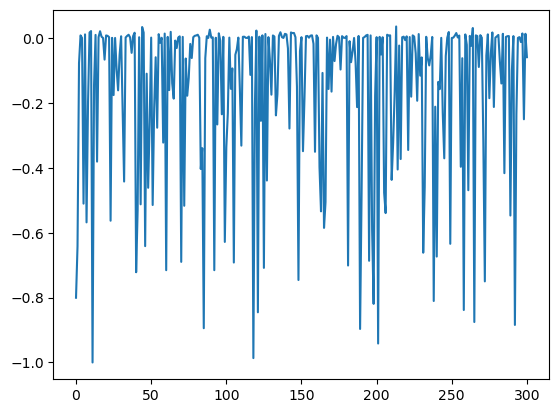

In [13]:
#### Notice how sign of H_samples[index]-y_ref matters

index = 0
plt.plot(a[index])
H_samples[index]-y_ref

array([[0.01143897]])

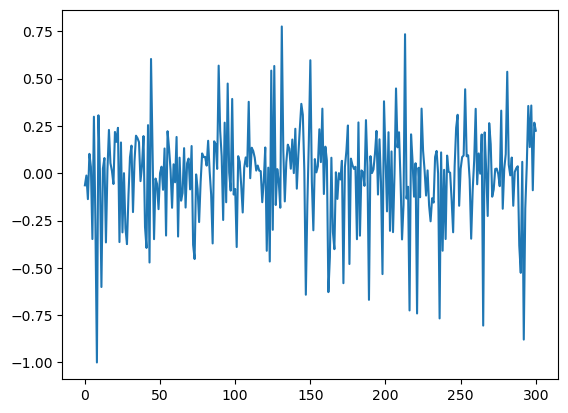

In [14]:
#### Notice how sign of H_samples[index]-y_ref matters

index = 1
plt.plot(a[index])
H_samples[index]-y_ref

array([[0.00683984]])

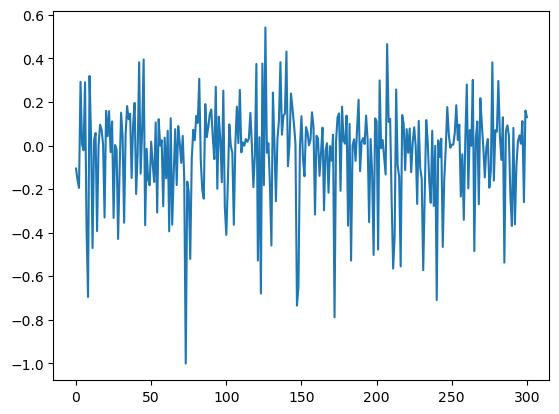

In [15]:
#### Notice how sign of H_samples[index]-y_ref matters

index = 100
plt.plot(a[index])
H_samples[index]-y_ref

In [16]:
index = 0
y = best_model.predict(M_samples[np.newaxis, index])
y_ref = y / 3.0

model_reg = keras.Model(inputs=inputs, outputs=x) 
model_reg.load_weights(mod_h5)
model_reg.compile(loss='mse', optimizer='adam',metrics=['mae'])
a_ref = regression_letzgus(model_reg, M_samples[np.newaxis, 0], y_ref)

model1, model2, model3 = triplicated_model_LRP_compatible(best_model, a_ref)
y1 = model1.predict(M_samples[np.newaxis, index])
y2 = model2.predict(M_samples[np.newaxis, index])
y3 = model3.predict(M_samples[np.newaxis, index])

analyzer_gradient1 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model1)
analyzer_gradient2 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model2)
analyzer_gradient3 = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model3)
a1 = np.zeros((samples, nx+1), dtype = np.float64)
a2 = np.zeros((samples, nx+1), dtype = np.float64)
a3 = np.zeros((samples, nx+1), dtype = np.float64)
a  = np.zeros((samples, nx+1), dtype = np.float64)

for sample in range(samples):
    a1[sample] = analyzer_gradient1.analyze(M_samples[sample][np.newaxis,:])
    a2[sample] = analyzer_gradient2.analyze(M_samples[sample][np.newaxis,:])
    a3[sample] = analyzer_gradient3.analyze(M_samples[sample][np.newaxis,:])
    a[sample]  = a1[sample] + a2[sample] + a3[sample]
    a[sample]  = a[sample] / np.max(np.abs(a[sample]))
    
y, y_ref, y-(y1+y2+y3)

2023-06-28 15:13:28.578418: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/Relu' id:308 op device:{requested: '', assigned: ''} def:{{{node dense_2/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:13:28.651959: W tensorflow/c/c_api.cc:291] Operation '{name:'total_12/Assign' id:2262 op device:{requested: '', assigned: ''} def:{{{node total_12/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_12, total_12/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:13:28.736062: W te

2023-06-28 15:13:29.092134: W tensorflow/c/c_api.cc:291] Operation '{name:'dense11_3/kernel/Assign' id:2320 op device:{requested: '', assigned: ''} def:{{{node dense11_3/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense11_3/kernel, dense11_3/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:13:29.691034: W tensorflow/c/c_api.cc:291] Operation '{name:'dense21_3/MatMul' id:2395 op device:{requested: '', assigned: ''} def:{{{node dense21_3/MatMul}} = MatMul[T=DT_FLOAT, _has_manual_control_dependencies=true, transpose_a=false, transpose_b=false](dense11_3/Relu, dense21_3/MatMul/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will tr

2023-06-28 15:13:31.469003: W tensorflow/c/c_api.cc:291] Operation '{name:'kernel_22/Assign' id:2850 op device:{requested: '', assigned: ''} def:{{{node kernel_22/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_22, kernel_22/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:13:31.554114: W tensorflow/c/c_api.cc:291] Operation '{name:'gradients_28/MaxNeuronSelection_6/Max_grad/range' id:2924 op device:{requested: '', assigned: ''} def:{{{node gradients_28/MaxNeuronSelection_6/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection_6/Max"], _has_manual_control_dependencies=true](gradients_28/MaxNeuronSelection_6/Max_grad/range/start, gradients_28/MaxNeuronSelection_6/Max_grad/Size, gradients_28/Ma

2023-06-28 15:13:33.245988: W tensorflow/c/c_api.cc:291] Operation '{name:'mul_56/x' id:3155 op device:{requested: '', assigned: ''} def:{{{node mul_56/x}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 1e-07>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:13:33.357310: W tensorflow/c/c_api.cc:291] Operation '{name:'Const_14' id:3152 op device:{requested: '', assigned: ''} def:{{{node Const_14}} = Const[_has_manual_control_dependencies=true, dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 0>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-28 15:13:33.445383: W tens

(array([[0.02310375]], dtype=float32),
 array([[0.00770125]], dtype=float32),
 array([[0.00763661]], dtype=float32))

array([[0.01273961]])

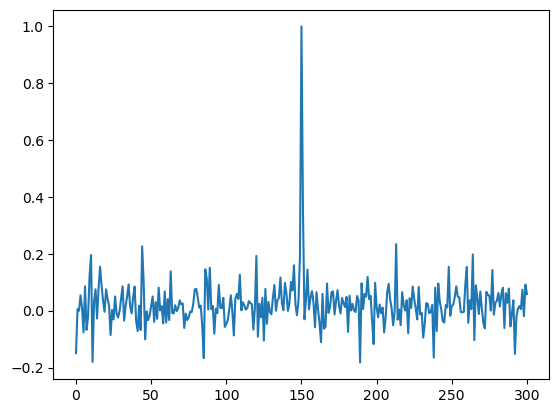

In [17]:
index = 0
plt.plot(a[index])
H_samples[index]-y_ref

array([[0.04994522]])

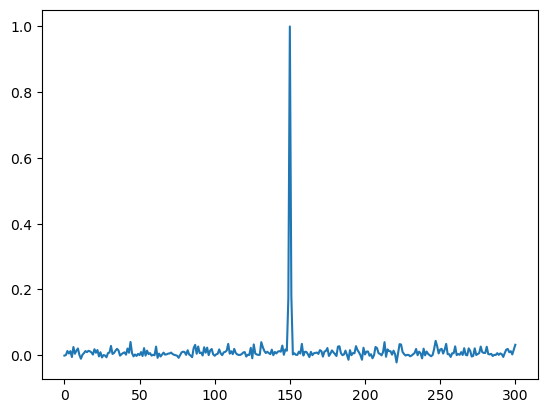

In [18]:
index = 1
plt.plot(a[index])
H_samples[index]-y_ref

array([[0.07245012]])

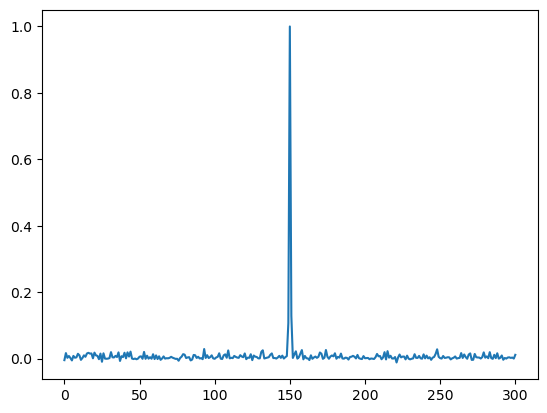

In [19]:
index = 2
plt.plot(a[index])
H_samples[index]-y_ref